# Des moindres carrés au machine learning

On détaille ici le problème de la régression par la méthode des moindres carrés : comment faire passer la meilleure droite au travers d'un ensemble de points expérimentaux ? 

## Notions abordées dans cette note

 - Comprendre les bases du machine learning (ou apprentissage statistique, ou statistique, ou science, ... )
 - Comprendre les différents ingrédients nécessaires à une régression linéaire : échantillon, données, fonction de coût
  - Comprendre les différences entre calculs statistiques et résultats déterministes
  - S'initier à la librairie `scikit-learn` en Python. Méthodes `fit` et `predict`
  - Comprendre les notions d'ensemble d'entraînement (_train set_) et d'ensemble de test (_test set_), de validation croisée (_cross-validation_) et de métrique (_score_)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Régression linéaire simple, méthode des moindres carrés

```{admonition} Exemple de la régression linéaire par méthode des moindres carrés
:class: seealso


```


Le problème de la régression linéaire par [méthode des moindres carés](https://fr.wikipedia.org/wiki/M%C3%A9thode_des_moindres_carr%C3%A9s) est caractérisé par les hypothèses et données suivants

 - On a une série de résultats expérimentaux (_ouput_ / _target_) $\left\{ y^{i}\right\}_{i\leq N}$ associés à une série de valeurs mesurables (_input_ / _features_) $\left\{ x^{i}\right\}_{i\leq N}$.
 - On **suppose** que le modèle liant résultats et valeurs mesurables est de la forme générale $y^{i}=\alpha+\beta x^{i}+\epsilon^{i}$ avec $\left(\alpha,\beta,x^{i},y^{i}\right)\in\mathbb{R}^{4}$. On **suppose** dans ce modèle que $\epsilon^{i}$ est une notion de [bruit blanc](https://en.wikipedia.org/wiki/White_noise) qui entâche les mesures.
 - On **propose** de rechercher un modèle de paramètres $\left(\alpha,\beta\right)$ répondant au cadre $\tilde{y}^{i}=\alpha+\beta x^{i}$ pour chaque point $y^{i}$ mesuré aléatoirement.

Pour obtenir la _meilleure_ représentation $\tilde{y}^{i}$ des données $y^{i}$, on va chercher à réduire au maximum la somme des écarts quadratiques entre le modèle supposé et le modèle proposé. On définit alors la fonction de coût

$$
r\left(y,\tilde{y}\right)=\frac{1}{2}\sum_{i=1}^{N}\left(y^{i}-\tilde{y}^{i}\right)^{2}
$$

Minimiser la distance quadratique entre les points expérimentaux et la courbe théorique revient à optimiser (= minimiser ici) le risque par rapport aux paramètres du modèle.

\begin{align*}
\begin{cases}
\left.\dfrac{\partial r\left(y,\tilde{y}\right)}{\partial\alpha}\right|_{\alpha=\hat{\alpha}} & =0\\
\\
\left.\dfrac{\partial r\left(y,\tilde{y}\right)}{\partial\beta}\right|_{\beta=\hat{\beta}} & =0
\end{cases} & \Rightarrow\begin{cases}
\hat{\alpha} & =\dfrac{1}{N}\sum\limits _{i=1}^{N}\left(y^{i}-\hat{\beta}x^{i}\right)=\bar{y}-\hat{\beta}\bar{x}\\
\\
\hat{\beta} & =\frac{\sum\limits _{i=1}^{N}\left(x^{i}-\bar{x}\right)\left(y^{i}-\bar{y}\right)}{\sum\limits _{i=1}^{N}\left(x^{i}-\bar{x}\right)^{2}}
\end{cases}
\end{align*}

C'est le seul modèle que l'on sache calculer exactement ! Les modèles plus complexes seront traités de façon numérique.

```{admonition} Problème d'entraînement supervisé
:class: hint

- On connaît l'ensemble des sorties $\left\{ y^{i}\right\}_{i\leq N}$ des $y^{i}$ (c'est ce que l'on a mesuré), l'ensemble des entrées $\left\{ x^{i}\right\}_{i\leq N}$ des $x^{i}$ (c'est ce que l'on a imposé au système $f:x^{i}\mapsto y^{i}$).
 - Comment calculer la meilleure représentation $\tilde{f}$ du système $f$ ? 
```

### Implémentation simple 

Illustrons la régression linéaire via le calcul effectué ci-dessus. 

```{admonition} Collecte ou génération de données ? 
:class: note
Pour illustrer nos exemples, on génère tout d'abord un jeu de fausses données. Dans la pratique ces données sont collectées, pas générées.

Des jeux de données sont disponibles dans les librairies de machine learning.
```

In [2]:
N = 25 # sample size
x = 5*np.random.random(N)
x.sort()
epsilon = np.random.gaussian(N)

y = 2+3*x+epsilon

x, y

(array([0.12409812, 0.28812646, 0.41153412, 0.78729847, 0.98033393,
        0.98567791, 1.10717943, 1.34880814, 1.72574145, 1.785843  ,
        1.83576216, 2.29487958, 2.30912514, 2.41444914, 2.49685377,
        2.65151599, 3.24008534, 3.35451458, 3.37164157, 3.3847324 ,
        3.56449538, 3.888835  , 3.96810256, 4.65339841, 4.73329783]),
 array([ 1.08169307,  3.36081922,  3.00977462,  4.76206653,  5.21270918,
         6.69939137,  4.86395321,  5.67755325,  5.96068257,  8.27342198,
         6.21579287,  8.31003514,  8.72352124,  8.25655919,  6.7318429 ,
         9.71056015, 12.53449589, 11.87853182, 14.37894416, 12.50254915,
        12.95988381, 13.11920213, 13.50694393, 15.58720971, 16.62639355]))

In [3]:
def linear_regression(x, y):
    """
    Take two series of floats (ideally, numpy array compatible objects) and returns
    the coefficients alpha and beta (two floats) corresponding to the linear
    regression
        y = alpha + beta * x
    """
    x, y = np.array(x), np.array(y)
    assert len(x.shape) == 1  # doesn't work for multi-dimensional array
    assert len(y.shape) == 1
    assert len(x) == len(y)
    xm, ym = np.mean(x), np.mean(y)
    numer = np.mean(x*y) - xm*ym
    denom = np.mean(x*x) - xm*xm
    beta = numer/denom
    alpha = ym - beta*xm
    return alpha, beta

alpha, beta = linear_regression(x,y)
alpha, beta

(1.751154806435145, 3.052796128116956)

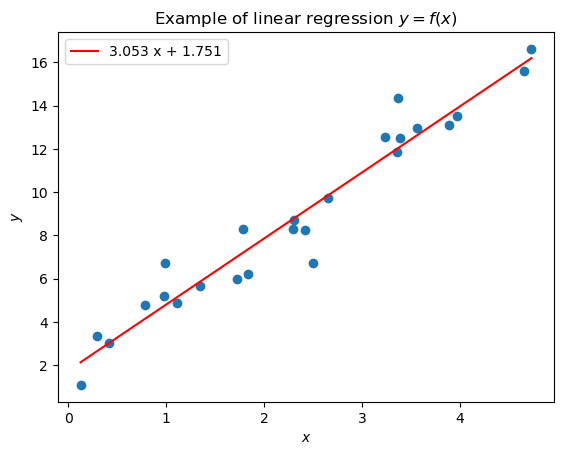

<Figure size 640x480 with 0 Axes>

In [4]:
y_fit = np.array([alpha+beta*t for t in x])

plt.scatter(x,y)
plt.plot(x,y_fit,'r',label="{:.4} x + {:.4}".format(beta,alpha))
plt.title("Example of linear regression $y = f(x)$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()
plt.clf()

### Implémentation via `sklearn`

Reproduisons les mêmes résultats à l'aide de la librairie [`scikit-learn`](https://scikit-learn.org/).

In [5]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=True) # intialise the model
lr.fit(x.reshape(-1,1), y.reshape(-1,1)) # fit the model
alpha = lr.intercept_[0] # catch the coefficients
beta = lr.coef_[0][0]

alpha, beta

(1.7511548064351556, 3.052796128116951)

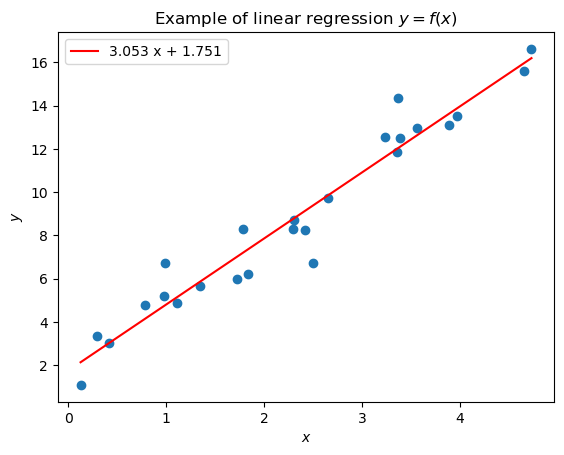

<Figure size 640x480 with 0 Axes>

In [6]:
y_fit = beta*x + alpha

plt.scatter(x,y)
plt.plot(x,y_fit,'r',label="{:.4} x + {:.4}".format(beta,alpha))
plt.title("Example of linear regression "+r"$y = f(x)$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend()
plt.show()
plt.clf()

### Régression linéaire par méthode des moindres carrés : bilan

 - On a un ensemble de résultats (labels/output/target) : $y^{i}$
 - On a un ensemble de données (input/features): $x^{i}$
 - On a un modèle : $\tilde{y}^{i}=\alpha+\beta x^{i}$, fonction des données selon des paramètres $\left\{ \alpha,\beta\right\}$  à déterminer
 - On a une fonction de coût : $r\left(y,\tilde{y}\right)$ liant le modèle aux résultats
 - On optimise (ici on a minimisé) la fonction de coût pour obtenir une estimation $\left\{ \hat{\alpha},\hat{\beta}\right\}$  des paramètres

## Prédiction et déterminisme

 - Une fois tous les couples $\left\{ \left(y^{i},x^{i}\right)\right\} _{i\leq N}$ utilisés, on obtient des estimations $\left(\hat{\alpha},\hat{\beta}\right)$ des paramètres fixés par la procédure d'optimisation
 - Une fois $\left(\hat{\alpha},\hat{\beta}\right)$ calculés, on peut calculer **tous** les $y=\hat{\alpha}+\hat{\beta}x$ associés à n'importe quel $x$, même ceux en dehors de $\left\{ x^{i}\right\} _{i\leq N}$

In [7]:
x_test = [[0,],[10,]]
y_test = lr.predict(x_test)

y_test

array([[ 1.75115481],
       [32.27911609]])

Une fois les paramètres $\alpha$ et $\beta$ obtenus, on dit que le modèle est **déterministe**, c'est-à-dire que l'on connaît tous les $\tilde{y}^{i} = \alpha + \beta x^{i}$ associés à tous les $x^{i}$, même ceux potentiellement hors de la zone d'apprentissage ... 

Dans les exemples ci-dessous, on suppose que l'on a ajusté notre droite sur les données en bleu, et on se demande comment évolue cette droite en dehors de sa zone d'apprentissage. On donne alors deux séries de points aléatoires en orange à droite de la zone d'apprentissage. La question se pose de savoir si la droite de régression est bien charactéristique de ces points oranges ... 

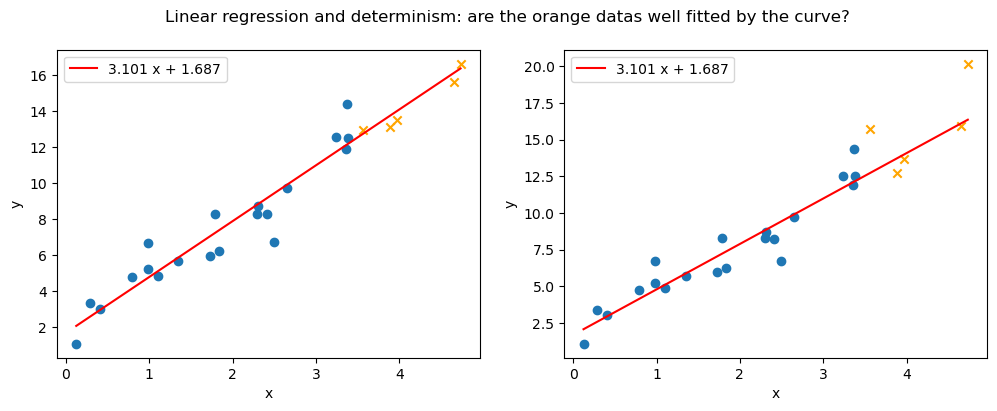

<Figure size 640x480 with 0 Axes>

In [8]:
x_new = x[:-5]
y_new = y[:-5]
alpha, beta = linear_regression(x_new, y_new)
y_fit = np.array([alpha + beta*t for t in x])

fig, axs = plt.subplots(1,2, figsize=(12,4))

for i,ax in enumerate(axs):
    ax.scatter(x_new,y_new)
    if i==0:
        x_old, y_old = x[-5:], y[-5:] # original datas
    else:
        x_old, y_old = x[-5:], 2*alpha + beta*x_old + 5*epsilon[-5:] # fake datas
    ax.scatter(x_old, y_old, marker='x', c='orange')
    ax.plot(x, y_fit, 'r', label="{:.4} x + {:.4}".format(beta, alpha))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()

fig.suptitle("Linear regression and determinism: are the orange datas well fitted by the curve?")
plt.show()
plt.clf()

Supposons que l'on continue d'observer le phénomène, et que l'on se pose la question de savoir si les nouvelles données vérifient toujours le modèle que l'on avait supposé au début.


```{admonition} Problème de validation
:class: hint
Comment savoir que les données non encore vues (les $x^{k}\notin\left\{ x^{i}\right\} _{i\leq N}$) rentrent bien dans le cadre du modèle $y=\alpha+\beta x$ postulé au départ à partir des exemples ?
```

### Échantillonage et validation croisée

On a besoin de méthodes pour 

Pour pouvoir évaluer notre modèle, on n'entraîne que sur une partie des données (**ensemble d'entraînement**), et on teste sur la partie restante (**ensemble de test**) que l'on a écarté lors de l'entraînement.

Une fois le modèle entraîné (méthode `fit` de chaque classe de modèle `sklearn`), on peut ensuite prédire de nouvelles situations (méthode `predict` de `sklearn`) et les comparer à des données de test (qui étaient dans le jeu de données de départ éventuellement, ou en collecter de nouvelles).

$$
\left\{ \left(x^{i},y^{i}\right)\right\} _{i=1}^{N}=\underset{\mathrm{train}}{\underbrace{\left\{ \left(x^{i},y^{i}\right)\right\} _{i=1}^{K}}}\oplus\underset{\mathrm{test}}{\underbrace{\left\{ \left(x^{i},y^{i}\right)\right\} _{i=K}^{N}}}
$$

Ce type d'échantillonage s'appelle une [cross-validation](https://fr.wikipedia.org/wiki/Validation_crois%C3%A9e) (ou validation croisée).

Dans les exemples ci-dessous, on utilise les données oranges comme données de test, et on calcule un score dit RSS pour quantifier l'écart entre les points de l'ensemble de test et les valeurs obtenues en ayant entraîné le modèle sur les données en bleu. 

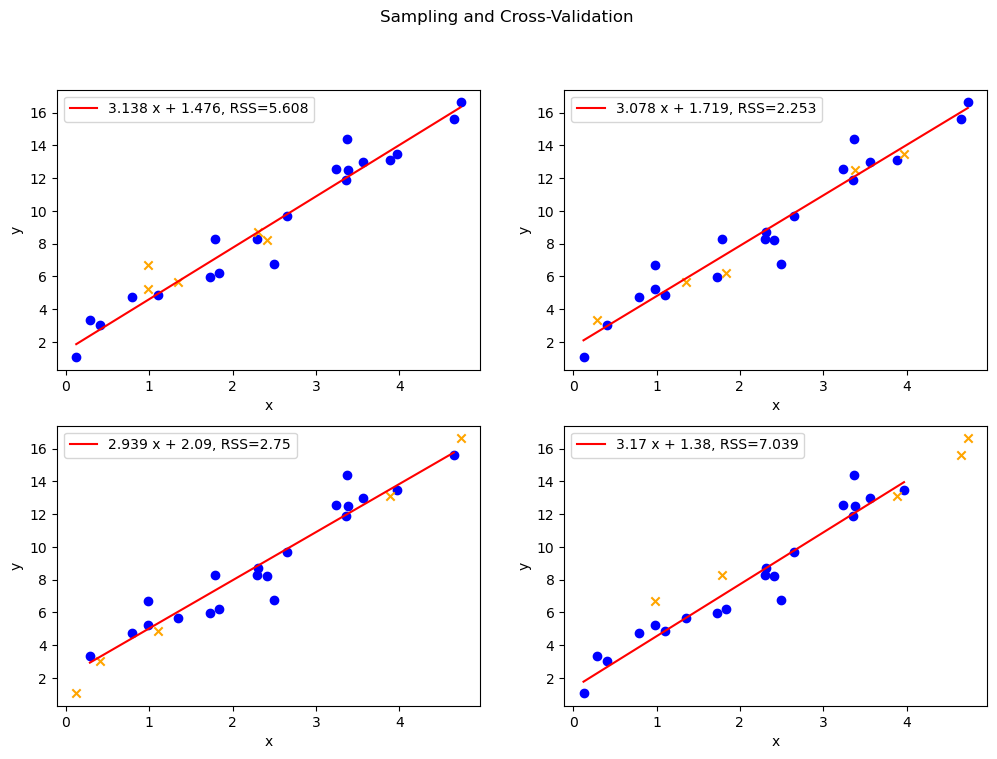

<Figure size 640x480 with 0 Axes>

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(12,8))

for line in axs:
    for ax in line:
        ind_sample = np.random.choice(range(len(x)),
                                      size = int(4*len(x)/5),
                                      replace=False)
        out_sample = np.array([i for i in range(len(x)) 
                               if i not in ind_sample])
        x_sample = x[ind_sample]
        y_sample = y[ind_sample]
        alpha, beta = linear_regression(x_sample, y_sample)
        x_out = x[out_sample]
        y_out = y[out_sample]
        y_predict = [alpha + beta*t for t in x_out]
        error = sum((y_predict[i]-y_out[i])**2 for i in range(len(y_predict)))
        ax.scatter(x_sample, y_sample, marker='o', c='blue')
        ax.scatter(x_out, y_out, marker='x', c='orange')
        x_sample.sort()
        y_fit = np.array([alpha + beta*t for t in x_sample])
        ax.plot(x_sample, y_fit, 'r', 
                label="{:.4} x + {:.4}, RSS={:.4}".format(beta,alpha,error))

        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.legend()

fig.suptitle("Sampling and Cross-Validation")    
plt.show()
plt.clf()

### Score

La séparation entre jeux d'entraînement et jeu de test permet aussi de calculer des scores : comment se comportent les données de test par rapport au modèle entraîné sur le jeu d'entraînement ? 

Pour la régression linéaire, le choix basique de score est la distance quadratique totale (ou _RSS_, _residual sum of squares_):

$$
\mathrm{RSS}=\sum_{i\in\left\{ \mathrm{test}\right\} }\left(y^{i}-\hat{y}^{i}\right)^{2}
$$

Le RSS est donné ci-dessus.

Il existe de nombreuses [fonctions de score](https://scikit-learn.org/stable/modules/model_evaluation.htm) dans les modules de machine learning ou d'analyse statistique.

```{admonition} Fonction de coût et fonction de score
:class: hint

La fonction utilisée pour _calculer_ les coefficients $\alpha$ et $\beta$, dite fonctiond e coût, est ici la même que la fonction utilisée pour _évaluer_ ces mêmes coefficients. Ici, cela fait sens puisque l'on cherche à minimiser l'écart quadratique entre les points exéprimentaux et la courbes d'ajustement. Mais cela n'est ni obligatoire, ni justifié dans tous les cas.

Trouver la bonne fonction de coût et de score est un des enjeux majeurs de l'apprentissage automatique et du raisonnement par optimisation.
```

### Jacknife et Bootstrapping

Une fois choisie une méthode de calcul de score entre le modèle entrainé et les données de test, on peut ensuite prendre des moyennes et leurs écarts-types pour mesurer les dispersions des paramètres et des scores dans plusieurs exemples indépendants. La forme ultime de ces échantillonages successifs s'appelle le [jacknife](https://en.wikipedia.org/wiki/Jackknife_resampling) ou le [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)). Ces méthodes consistent à tirer aléatoirement un grand nombre d'échantillons (avec remise dans le cas du bootstrapping, sans remise dans le cas du jacknife), à calculer la droite de régression (ou entraîner un modèle d'apprentissage dans le cas général) pour chacun de ces échantillons, puis de calculer la moyenne et l'écart-type (ou autre statistiques) des données ainsi calculées.

C'est l'ensemble des courbes rouges sur le graphique ci-dessous, obetnues ici par bootstrapping.

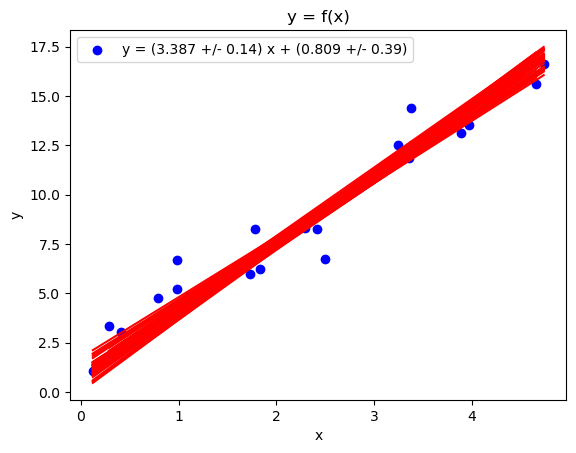

RSS = (6.687 +/- 4.6)


<Figure size 640x480 with 0 Axes>

In [10]:
all_alphas, all_betas, all_rss = list(), list(), list()
for _ in range(50):
    ind_sample = np.random.choice(range(len(x)),
                                  size = int(4*len(x)/5),
                                  replace=False)
    out_sample = np.array([i for i in range(len(x)) if i not in ind_sample])
    x_sample = x[ind_sample]
    y_sample = 2 + 3*x_sample + 2*epsilon[ind_sample]
    x_sample.sort()
    y_sample.sort()
    x_out = x[out_sample]
    y_out = 2 + 3*x_out + epsilon[out_sample]
    x_out.sort()
    y_out.sort()
    alpha, beta = linear_regression(x_sample,y_sample)
    y_predict = np.array([alpha + beta*t for t in x_out])
    y_fit = np.array([alpha+beta*t for t in x_sample])
    error = sum((y_predict[i]-y_out[i])**2 for i in range(len(y_predict)))
    all_alphas.append(alpha)
    all_betas.append(beta)
    all_rss.append(error)
    plt.plot(x_sample,y_fit,'r')
string = "y = ({:.4} +/- {:.2}) x + ({:.4} +/- {:.2})".format(np.mean(all_betas),
                                                              np.std(all_betas),
                                                              np.mean(all_alphas),
                                                              np.std(all_alphas))
plt.scatter(x,y,marker='o',c='blue',label=string)
plt.title("y = f(x)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()
plt.clf()

print("RSS = ({:.4} +/- {:.2})".format(np.mean(all_rss), np.std(all_rss)))